In [1]:
import numpy as np
import scipy.special as sp
import random
from matplotlib import pyplot as plt
from itertools import permutations

## Generating Coefficients

The following function gives us the matrix $\Lambda - L$. In the notes, it's used to calculate $C(\vec{z})$, the coefficients for the eigenfunction, and is defined as 
$$C(\vec{z}) = \det (\Lambda - L)^{-1}$$
where $\Lambda$ is the diagonal matrix with diagonal entries of $L/z_i$ for $i = 1 \dots N$ and $L$ is defined as 
$$L_{ij} = \begin{cases}\Delta\frac{1 + z_j^2 - \Delta z_j}{(1 + z_i z_j - \Delta z_i)(1 + z_i z_j - \Delta z_j)} & i \neq j \\ -\sum_{i \neq j}L_{ij} & i = j\end{cases}$$

In [2]:
# used to define L_{ij} when i isn't equal to j
def M(z, i, j, d):
    return d*( 1 + z[i]*z[i] - d*z[i] )/((1 + z[i]*z[j] - d*z[j])*(1 + z[i]*z[j] - d*z[i]))

# gives C(z) proper
def Cmat(z, d, L):
    n = len(z)
    diag =0
    mat = [[ - M(z, i, j, d) for i in range(n)] for j in range(n) ]
    for i in range(n):
        # need to "remove" the entry at M[i][i] by cancelling it out 
        diag = sum(mat[i]) +M(z, i, i, d)
        mat[i][i] = -diag + (L/z[i])
    return(mat)

Here, we're calculating the actual coefficient to be multiplied by the eigenfunction and time dependent part of $U(\vec{x}, t)$. Instead of just being $\det (\Lambda - L)^{-1}$, we also multiply by $\prod_{i = 1}^N z_i^{-y_i - 1}$, which was factored out from the original formulation of $U(\vec{x}, t)$.

In [3]:
def Coeff(y, z, d, L):
    n = len(z)
    terms = [ z[i]**(y[i]+1) for i in range(n)] 
    coeff = np.prod(terms)
    coeff = coeff*np.linalg.det(Cmat(z, d, L))
    coeff = 1/coeff
    return coeff

#### General code usage examples:

In [4]:
z = [1,2,3]
y = [1,2,3]
d = 1
L = 2
Coeff(y, z, d, L)

0.00016325464459463873

In [5]:
Cmat([1,2,3], 1, 10)

[[13.833333333333334, -1.5, -2.3333333333333335],
 [-0.5, 5.85, -0.35],
 [-0.3333333333333333, -0.15, 3.816666666666667]]

## Generating the Eigenfunction
Next we want to generate the eigenfunction, which is given by 
$$\sum_{\sigma \in S_N} A_\sigma (\vec{z}) \prod_{i = 1}^N z_{\sigma(i)}^{x_i}$$
where $S_N$ is the symmetric group of the set $\{1, 2, \dots, N\}$ (all possible bijective functions on this set), $A_\sigma$ is given by
$$A_\sigma (\vec{z}) = \prod_{i < j,\ \sigma(i) > \sigma(j)} \left(-\frac{1 + z_i z_j - \Delta z_j}{1 + z_i z_j - \Delta z_i}\right)$$
The product is basically taking every inversion $(i, j)$ in $\sigma$ and using it as part of the product. So to find this, we need a way to generate both all possible $\sigma \in S_N$ and all inversions given some specific $\sigma$. 

Below is an example of finding $S_N$ for a small number of elements ($N = 3$). Each element in tuple represents the output of $\sigma(i)$ where $i$ is the index. Due to normal computing conventions, instead of going from 1 to $N$, it goes from 0 to $N - 1$.

In [6]:
list(permutations(range(3)))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

This function takes an argument of the form above (a list of lists representing $\sigma$) and returns the set of all inversions within it (a list where each element is a tuple $(i, j)$).

In [7]:
def inversions(s):
    n = len(s)
    inv = []
    for i in range(n):
        for j in range(i+1, n):
            if s[i] > s[j]:
                inv.append((s[i],s[j]))
    return inv

In [8]:
inversions((0,2,1))

[(2, 1)]

In [9]:
def A(z, s, d):
    n = len(z)
    inv = inversions(s)
    terms = [ -(1 + z[i[0]]*z[i[1]] - d*z[i[0]])/(1 + z[i[0]]*z[i[1]] - d*z[i[1]]) for i in inv]
    return np.prod(terms)

In [10]:
z = [1,2]
s = (1,0)
d=4
A(z, s, d)

-5.0

In [11]:
def eigenfun(x, z, d):
    n = len(z)
    per = list(permutations(range(n)))
    final_term=0
    term = 0
    for s in per:
        term = A(z, s,d)
        for i in range(n):
            term = term*(z[s[i]]**(x[i]))
        final_term = final_term + term
    return final_term

## Solutions to the Bethe equations
$\vec{z} = [z_1, z_2, \dots, z_N]$ is a list containing the solutions to the Bethe equations, given by

$z_i^L = -\prod_{j=1}^N\left( -\frac{1 + z_i z_j - \Delta z_i}{1 + z_i z_j - \Delta z_j}\right), \quad i =1, 2, \dots, N$

The function below returns the right hand side of the equation above, given $i$, $\Delta$, and an approximation of $\vec{z}$.

In [12]:
def BE(z,i,d):
    n = len(z)
    term = -1 if n % 2 == 0 else 1             # calculate sign
    for j in range(n):
        term= term*((1 + z[i]*z[j] - d*z[i])/(1 + z[i]*z[j] - d*z[j]))
    return term

In [13]:
BE((1,2), 1, 0)

-1.0

We aren't solving these equations exactly. Instead, we're using a fixed point method to approximate the solutions. The function below simulates a single step of this method. 

The method itself is finding the roots for $\vec{a}_{n+1}^L = -BE(\vec{a_n}, \Delta)$ where $BE(\vec{a_n}, \Delta)$ is defined above. Each iteration gets us closer and closer to the real roots. At every step, we keep only the closest one to our previous iterate (a complex polynomial of degree $L$ gives $L$ different roots at every step, so we need to pick one).

In [14]:
def seq_update(z,d,L):
    n = len(z)
    w = []
    for i in range(n):
        pol = [1]
        pol.extend([0]*(L-1))
        pol.append(- BE(z, i, d))
        roots = np.roots(pol)
        roots = [x-z[i] for x in roots]
        w.append(min(roots, key=np.abs) + z[i])
    return w

In our initial guess for the solution, we assume $\Delta = 0$, which forces all of our solutions to be roots of unity.

In [15]:
def BE_sol_initial(I,L):
    n = len(I)
    pol = [1]
    pol.extend([0]*(L-1))
    pol.append((-1)**n)
    roots = np.roots(pol)
    sol = []
    for i in I:
        sol.append(roots[i])
    return sol

In [16]:
BE_sol_initial((1,2), 4)

[(-0.7071067811865477-0.7071067811865476j),
 (0.7071067811865471+0.7071067811865469j)]

Given some number `N` of quantum coins that are heads within our quantum ring of size `L`, we want to check the conjecture against all possible initial positions, meaning we need to generate all possible initial positions. This is what the function below does, returning all tuples of size `N` such that every element in the tuple is an integer in $[0, L]$ and every successive element is greater than any of the previous elements. This second condition is here to avoid duplicate condition checks (reducing computations) and the order of the heads doesn't matter.

In [17]:
tuple([1,2])

(1, 2)

In [18]:
def tuple_combinations(N,L):
    def helper(current_tuple, index):
        if index == N:
            result.append(current_tuple)
            return
        if index == 0:
            for i in range(L):
                helper(current_tuple + (i,), index+1)
        else:
            for i in range(current_tuple[-1]+1, L):
                helper(current_tuple + (i,), index+1) 
    result = []
    helper(tuple(), 0)
    return result

In [19]:
N=1
L=10
print(tuple_combinations(N,L))

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)]


If we wanted to, we could also include all permutations of the tuple combinations we originally generated. This should give all possible combinations of integers between $[0, L]$ with no repeats.

In [20]:
N=2
L=3
config = []
all_config = tuple_combinations(N,L)
for z in all_config:
    config.extend(list(permutations(z)))
print(config)

[(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)]


Finally, it's time to run the fixed point method to solve the Bethe equations. We give this function the number of heads `N`, the length of the ring `L`, $\Delta$ = `d`, and the number of times to run the method on each initial condition (`updates`). For each possible initial condition, it will generate the solutions to the Bethe equations for it. 

In [21]:
def BE_all_sol(N,L,d,updates):
    all_tuples = tuple_combinations(N,L)
    sol = []
    for I in all_tuples:
        initial = BE_sol_initial(I,L)
        for k in range(updates):
            initial = seq_update(initial, d, L)
        sol.append(initial)
    return sol

In [22]:
BE_all_sol(3,10, 0.1, 10)

[[(-1.0000000000000002+4.440892098500626e-16j),
  (-0.803778248598265+0.5949290101182716j),
  (-0.8037782485982644-0.5949290101182722j)],
 [(-0.9999484167750532-0.01015695766779312j),
  (-0.81011583928648+0.5862698414016897j),
  (-0.2975546439229571+0.9547047888640143j)],
 [(-0.999992393304178+0.0039004273851085403j),
  (-0.8022195162176727+0.5970291850483377j),
  (-0.2943588920128158-0.9556949527401442j)],
 [(-0.9998630272006976-0.016550735242209402j),
  (-0.8175386262159607+0.575873766241283j),
  (0.3385323976333604+0.9409547362932021j)],
 [(-0.9999472403409959+0.010272124143752337j),
  (-0.8002420857927913+0.5996770832089585j),
  (0.33274274318264624-0.9430176386787715j)],
 [(-0.9996241530647371+0.027414459863483787j),
  (-0.7968441558096949+0.6041848983150256j),
  (0.8362013620275074-0.5484225397841906j)],
 [(-0.994607016745876-0.1037153905641135j),
  (-0.9852809625339173+0.17094275319016838j),
  (0.9976967532135913+0.06783206194020995j)],
 [(-0.9996241530647383+0.02741445986347512

## Checking initial conditions
What we're looking at here are the calculations required to generate the transition matrix (a matrix representation of the Hamiltonian operator $H$) for various values of $N$ and $L$.

In [23]:
# This function checks whether this matrix looks like
# the identity (plus/minus epsilon, our allowed error).
# Takes a list of lists as the matrix. 
def checkIdentity(matrix, epsilon):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if (i == j and abs(matrix[i][j] - 1) > epsilon) \
                or (i != j and abs(matrix[i][j]) > epsilon): 
                return False
    return True

In [31]:
# testing stuff here 
N=2
L=5
d=0.01
ord_sol = BE_all_sol(N,L, d, 10)
all_sol = []
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
all_config = tuple_combinations(N,L)
#print(all_config)
trans_mat = [ [ np.abs(sum([Coeff(y, z, d, L)*eigenfun(x, z, d) for z in all_sol])) for y in all_config] for x in all_config]
print(np.matrix(trans_mat))
print(checkIdentity(trans_mat, 10**(-10)))

[[1.00000000e+00 4.57966998e-16 4.71857541e-16 1.45881890e-16
  4.22076438e-17 8.33389756e-17 1.23520108e-15 8.46658801e-16
  7.77158053e-16 0.00000000e+00]
 [4.16564866e-16 1.00000000e+00 2.50185378e-16 5.96906224e-16
  5.41233725e-16 4.99600361e-16 1.39470041e-16 5.55111512e-17
  5.27538508e-16 7.91033905e-16]
 [5.41233725e-16 2.77555756e-17 1.00000000e+00 1.94412899e-16
  4.16333634e-17 2.49800181e-16 5.27367349e-16 5.55284958e-16
  1.11022302e-16 1.37391852e-15]
 [9.12668999e-17 8.18835420e-16 1.67829453e-16 1.00000000e+00
  5.48216534e-16 6.24502861e-16 2.08166817e-16 6.97350207e-17
  5.13478149e-16 1.39470041e-16]
 [1.59594560e-16 4.71895804e-16 8.32667268e-17 1.59745334e-16
  1.00000000e+00 5.83032276e-16 5.82908389e-16 1.31838984e-16
  1.43048962e-17 8.74410766e-16]
 [2.22044605e-16 7.21720022e-16 1.68830575e-16 5.55111512e-16
  3.06020169e-16 1.00000000e+00 1.67110694e-16 6.10662088e-16
  4.99793071e-16 5.55111512e-17]
 [1.01317356e-15 3.60889197e-16 5.82908389e-16 4.16333634e

In [44]:
# more testing stuff 
firstSolPerms = list(permutations(ord_sol[0]))
for z in firstSolPerms:
    print("Just the coeff:", Coeff(all_config[0], z, d, L))
    print("First way:", Coeff(all_config[0], z, d, L)*eigenfun(all_config[1], z, d))
    print("Second way:", Coeff(all_config[1], z, d, L)*eigenfun(all_config[0], z, d))

Just the coeff: (-0.012330129754625265-0.03813614047808559j)
First way: (0.0001656309168229543+0.07621833153338146j)
Second way: (-0.0446870433074419-0.014483921646319998j)
Just the coeff: (-0.04007984454505804+5.8065257697667405e-05j)
First way: (-0.07243675809787456-0.02371028408946314j)
Second way: (-0.027584083873609878-0.0380241257975982j)


In [24]:
N=4
L=7
d=0.01
ord_sol = BE_all_sol(N,L, d, 10)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
config = []
all_config = tuple_combinations(N,L)
#print(all_config)
trans_mat = [ [ np.abs(sum([Coeff(y, z, d, L)*eigenfun(x, z, d) for z in all_sol])) for y in all_config] for x in all_config]
print(np.matrix(trans_mat))

In [43]:
# checking that our solutions actually satisfy the Bethe equations
N=2
L=7
d=0.01
ord_sol = BE_all_sol(N,L, d, 100)
ord_sol[2][1]**L - BE(ord_sol[2], 1, d)

(3.4416913763379853e-15+8.881784197001252e-16j)

In [44]:
N=2
L=3
d=0.01
ord_sol = BE_all_sol(N,L, d, 10)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
config = []
all_config = tuple_combinations(N,L)
#print(all_config)
trans_mat = [ [ np.abs(sum([Coeff(y, z, d, L)*eigenfun(x, z, d) for z in all_sol])) for y in all_config] for x in all_config]
print(np.matrix(trans_mat))

[[7.50000009e-01 6.68479438e-09 2.49999997e-01 2.50000009e-01
  7.23422700e-09 2.49999991e-01]
 [6.68479547e-09 1.49999941e+00 8.38222272e-09 6.68479413e-09
  4.99999409e-01 7.23422694e-09]
 [2.49999997e-01 8.38222478e-09 7.50002338e-01 2.50000003e-01
  8.38222286e-09 2.49999997e-01]
 [2.50000009e-01 6.68479538e-09 2.50000003e-01 7.50000009e-01
  6.68479425e-09 2.50000009e-01]
 [7.23422622e-09 4.99999409e-01 8.38222494e-09 6.68479533e-09
  1.49999941e+00 6.68479427e-09]
 [2.49999991e-01 7.23422627e-09 2.49999997e-01 2.50000009e-01
  6.68479538e-09 7.50000009e-01]]


In [26]:
N=2
L=5
d=0.1
y=[-1,-1]
ord_sol = BE_all_sol(N,L, d, 10)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
[Coeff(y, z, d, L) for z in all_sol]

[(0.012604368615870382-0.0387922577855527j),
 (0.012604368615870375-0.03879225778555268j),
 (0.012604368615870382+0.0387922577855527j),
 (0.012604368615870375+0.03879225778555268j),
 (-0.03316190838596017-0.02409353675221766j),
 (-0.03316190838596017-0.024093536752217662j),
 (-0.03316190838596017+0.02409353675221766j),
 (-0.03316190838596017+0.024093536752217662j),
 (0.04026623367940393+2.235224987290559e-18j),
 (0.04026623367940393-2.235224987290559e-18j),
 (-0.030604906692462394+0.0222357662777098j),
 (-0.030604906692462387+0.02223576627770979j),
 (0.012275661153956969+0.037780600241475164j),
 (0.012275661153956974+0.037780600241475164j),
 (0.012275661153956969-0.037780600241475164j),
 (0.012275661153956974-0.037780600241475164j),
 (-0.030604906692462394-0.0222357662777098j),
 (-0.030604906692462387-0.02223576627770979j),
 (0.03934541680603303+0j),
 (0.03934541680603303+0j)]

In [27]:
N=2
L=5
d=0.1
y=[-1,-1]
ord_sol = BE_all_sol(N,L, d, 10)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
print(all_sol)

[((-0.9999004932239464-0.014106865367932375j), (-0.2955698188574209+0.9553211408634229j)), ((-0.2955698188574209+0.9553211408634229j), (-0.9999004932239464-0.014106865367932375j)), ((-0.9999004932239464+0.014106865367932375j), (-0.2955698188574209-0.9553211408634229j)), ((-0.2955698188574209-0.9553211408634229j), (-0.9999004932239464+0.014106865367932375j)), ((-0.9982161702461364-0.05970324496318069j), (0.8426665326923638+0.5384358036760085j)), ((0.8426665326923638+0.5384358036760085j), (-0.9982161702461364-0.05970324496318069j)), ((-0.9982161702461364+0.05970324496318069j), (0.8426665326923638-0.5384358036760085j)), ((0.8426665326923638-0.5384358036760085j), (-0.9982161702461364+0.05970324496318069j)), ((-0.29103974563711354+0.9567109628615562j), (-0.29103974563711354-0.9567109628615562j)), ((-0.29103974563711354-0.9567109628615562j), (-0.29103974563711354+0.9567109628615562j)), ((-0.2695024611955235+0.9629997006279685j), (0.7840690931242389+0.6206735512387598j)), ((0.7840690931242389

# Partition Function

In [28]:
def energy(z,d):
    return sum([i +1/i - 2*d for i in z])

In [29]:
def partition(sol,d,b):
    return sum([np.exp(-b*energy(z,d)) for z in sol])

In [30]:
def sum_energy(sol, d, b):
    return sum([ energy(z,d)*np.exp(-b*energy(z,d))for z in sol] )

C:\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


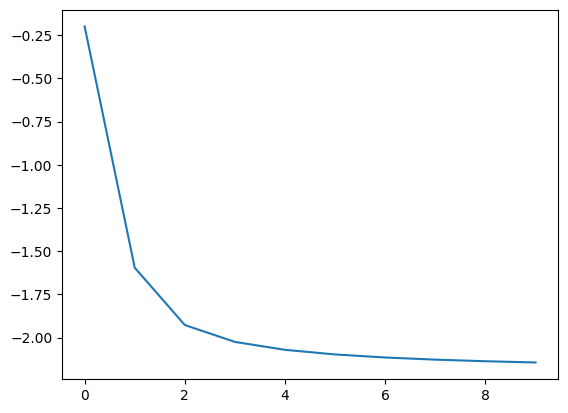

In [31]:
N=1
L=51
d=0.1
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

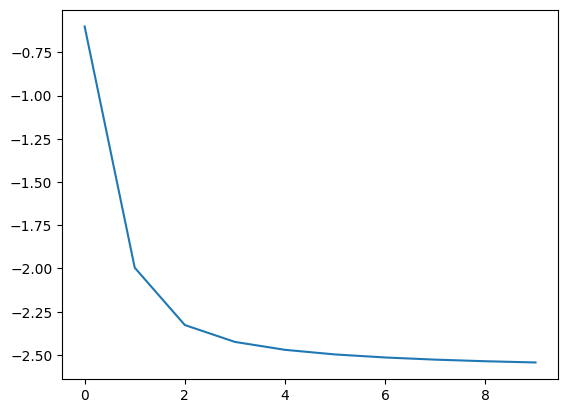

In [32]:
N=1
L=51
d=0.3
ord_sol = BE_all_sol(N,L, d, 100)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

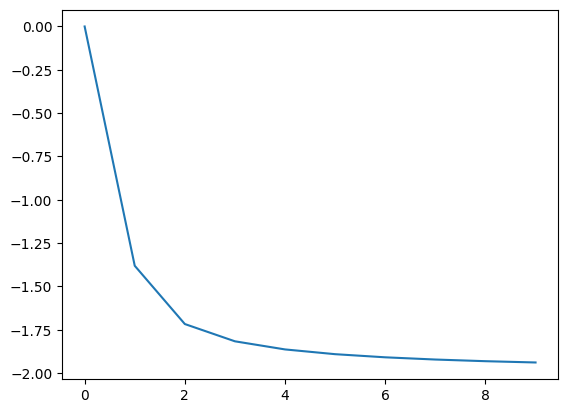

In [33]:
N=2
L=51
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

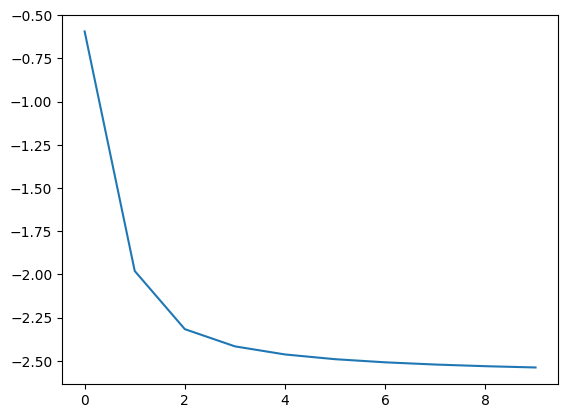

In [34]:
N=2
L=51
d=0.3
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

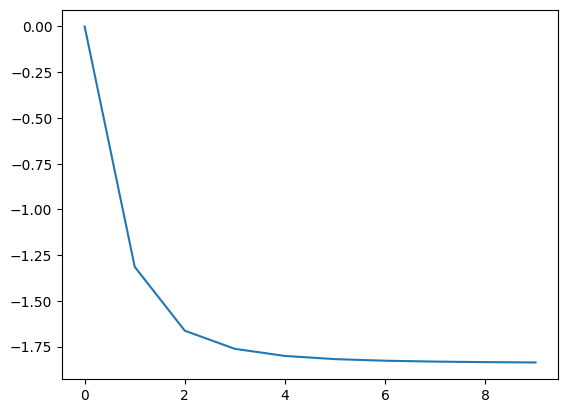

In [35]:
N=2
L=11
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

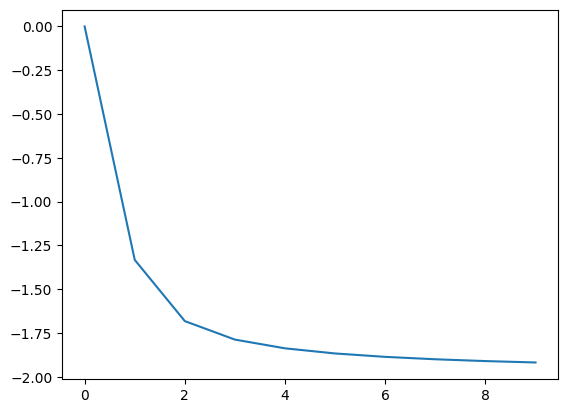

In [36]:
N=5
L=51
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

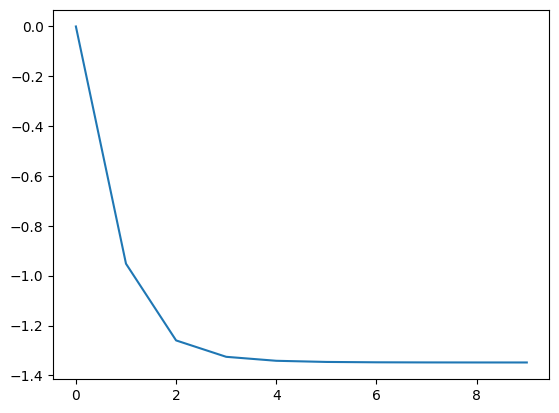

In [430]:
N=5
L=11
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

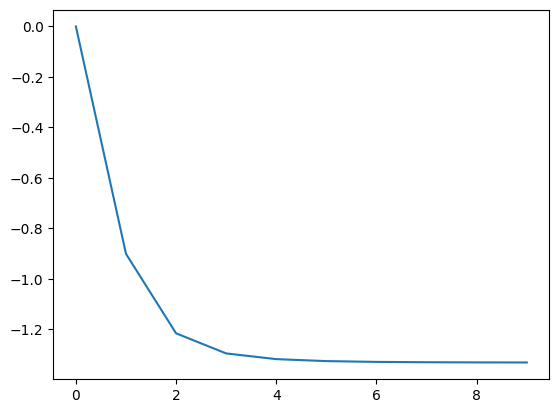

In [431]:
N=8
L=17
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

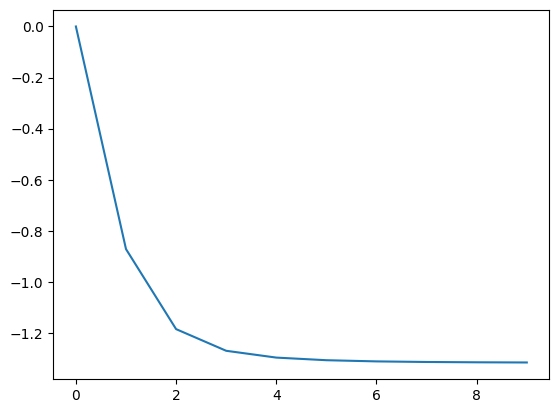

In [432]:
N=12
L=25
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
part = [ partition(ord_sol, d, b) for b in range(10)]
avg_ene = [sum_energy(ord_sol, d, b)/(N*partition(ord_sol, d, b)) for b in range(10) ]
plt.plot(range(10), avg_ene)

# Spin Correlation

In [437]:
N=2
L=5
d=0
ord_sol = BE_all_sol(N,L, d, 10)
all_config = tuple_combinations(N,L)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))

In [607]:
def sub_config_one(j,all_config):
    config = []
    for x in all_config:
        if j in x:
            config.append(x)
    return config

In [608]:
N=1
L=5
j=2
all_C = tuple_combinations(N,L)
subC = sub_config_one(j, all_C)
print(subC)

[(2,)]


In [593]:
def prob_config(y, x, t, sols, d, L):
    terms = [Coeff(y, z, d, L)*eigenfun(x, z, d)*np.exp(-1j*t*energy(z, d)) for z in sols]
    return np.abs(sum(terms))**2

In [609]:
N=1
L=5
t=1
d=0
all_C = tuple_combinations(N,L)
y = [2 + i for i in range(N)]
ord_sol = BE_all_sol(N,L, d, 10)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
[prob_config(y, x, t, all_sol, d, L) for x in all_C]

[0.14114770734256593,
 0.3336897520252522,
 0.050325081264363365,
 0.33368975202525325,
 0.1411477073425651]

In [610]:
def prob_one(y, x_one , t,sols, d, L, all_config):
    subC = sub_config_one(x_one, all_config)
    terms = [ prob_config(y, x, t, sols, d, L) for x in subC]
    return sum(terms)

In [611]:
N=2
L=5
t=10
d=0.1
y = [2 + i for i in range(N)]
all_C = tuple_combinations(N,L)
ord_sol = BE_all_sol(N,L, d, 100)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))
dist = [prob_one(y, x, t, all_sol, d, L, all_C) for x in range(L)]
print(dist)
print(sum(dist))

[0.40098598918058476, 0.43191219114463075, 0.3675948142650681, 0.367594814265078, 0.4319121911446398]
2.0000000000000013


In [612]:
L= 11
N= 1
IC_one = [int(L/2)]
d=0
acc=10
all_C = tuple_combinations(N,L)
ord_sol = BE_all_sol(N,L, d, acc)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))

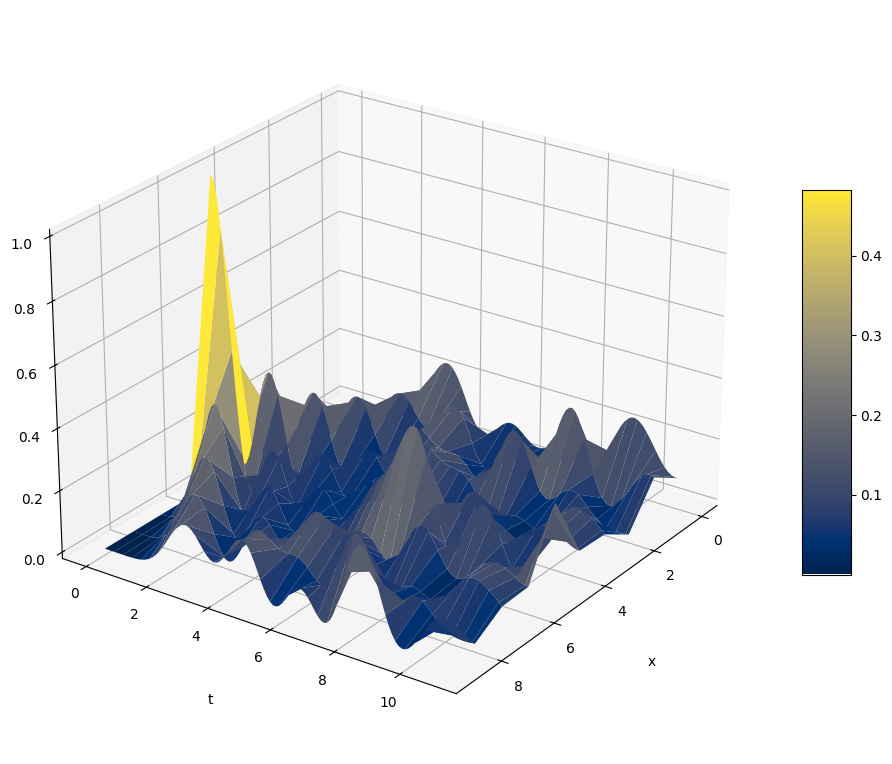

In [614]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')


x = np.arange(0, L-1, 1)
t = np.arange(0, L, 0.1)


X, T = np.meshgrid(x, t)
Z = np.array([[prob_one(IC_one, x1, t1 , all_sol, d, L, all_C)  for x1 in x] for t1 in t])
#Z = prob_one(Step_IC, X, T, all_sol, d, N, L)

surf = ax.plot_surface(X, T, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('t', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

ax.view_init(25, 35)

plt.show()

In [620]:
L= 5
N= int(L/2)
Step_IC = [int(L/4) + i for i in range(N)]
d=0
acc=10
all_C = tuple_combinations(N,L)
ord_sol = BE_all_sol(N,L, d, acc)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))

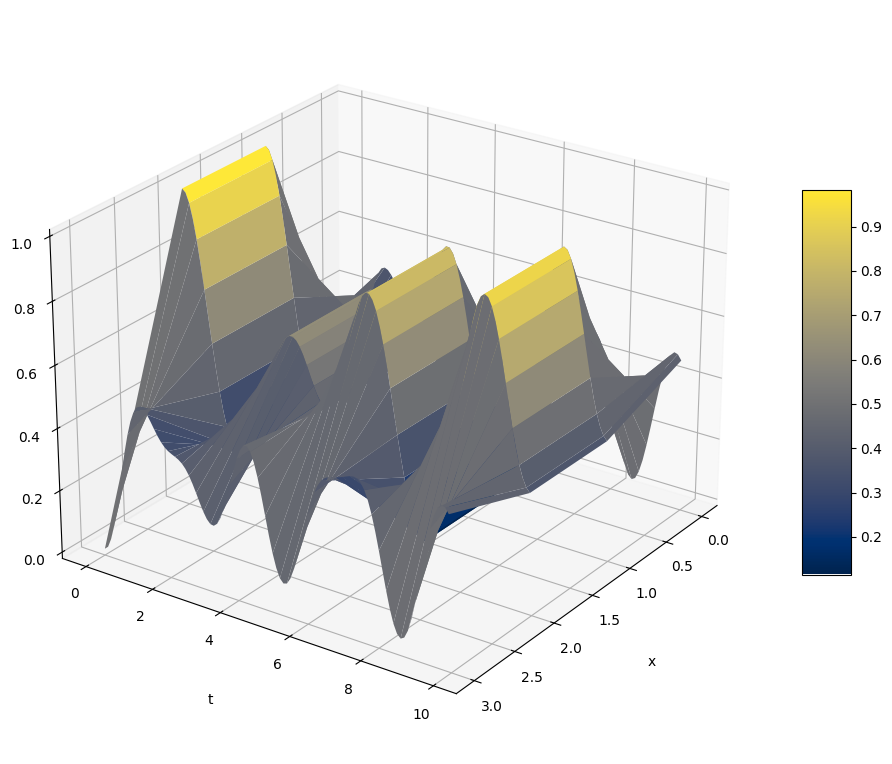

In [623]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')


x = np.arange(0, L-1, 1)
t = np.arange(0, 2*L, 0.1)


X, T = np.meshgrid(x, t)
Z = np.array([[prob_one(Step_IC, x1, t1 , all_sol, d, L, all_C)  for x1 in x] for t1 in t])
#Z = prob_one(Step_IC, X, T, all_sol, d, N, L)

surf = ax.plot_surface(X, T, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('t', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

ax.view_init(25, 35)

plt.show()

In [624]:
L= 7
N= int(L/2)
Step_IC = [int(L/4) + i for i in range(N)]
d=0
acc=10
all_C = tuple_combinations(N,L)
ord_sol = BE_all_sol(N,L, d, acc)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))

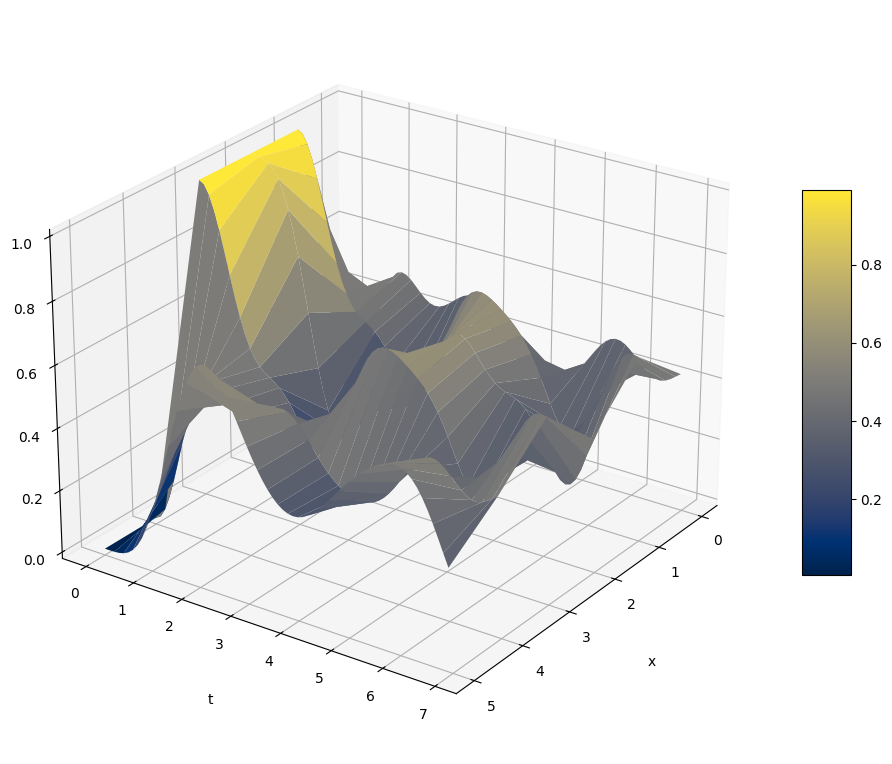

In [625]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')


x = np.arange(0, L-1, 1)
t = np.arange(0, 1*L, 0.1)


X, T = np.meshgrid(x, t)
Z = np.array([[prob_one(Step_IC, x1, t1 , all_sol, d, L, all_C)  for x1 in x] for t1 in t])
#Z = prob_one(Step_IC, X, T, all_sol, d, N, L)

surf = ax.plot_surface(X, T, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('t', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

ax.view_init(25, 35)

plt.show()

In [626]:
L= 11
N= int(L/2)
Step_IC = [int(L/4) + i for i in range(N)]
d=0
acc=10
all_C = tuple_combinations(N,L)
ord_sol = BE_all_sol(N,L, d, acc)
all_sol =[]
for z in ord_sol:
    all_sol.extend(list(permutations(z)))

In [627]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')


x = np.arange(0, L-1, 1)
t = np.arange(0, 1*L, 0.1)


X, T = np.meshgrid(x, t)
Z = np.array([[prob_one(Step_IC, x1, t1 , all_sol, d, L, all_C)  for x1 in x] for t1 in t])
#Z = prob_one(Step_IC, X, T, all_sol, d, N, L)

surf = ax.plot_surface(X, T, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('t', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

ax.view_init(25, 35)

plt.show()